# Create Signal

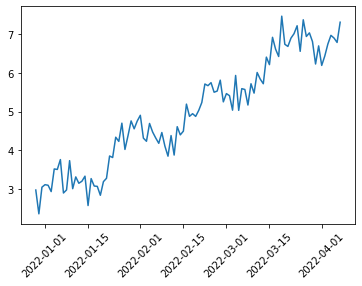

In [1]:
# create random signal

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd

time = np.arange(0, 100, 1)
signal_np = 0.5*np.sin((2*np.pi/25)*time) + 2*np.ones(len(time)) + 0.05*time + np.random.rand(len(time))

# create dataframe
date_today = datetime.now()
days = pd.date_range(date_today, date_today + timedelta(len(time)-1), freq='D')
signal = pd.Series(signal_np)
signal.index = days

plt.plot(signal)
plt.xticks(rotation=45)
plt.show()

# Test for Stationarity

In [2]:
# ADF

from statsmodels.tsa.stattools import adfuller

adftest = adfuller(signal, autolag="AIC")
print("test statistic", adftest[0])
print("p-value", adftest[1])
print("critical values", adftest[4])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


test statistic -0.4976388509274761
p-value 0.8924764360091787
critical values {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}


In [3]:
# KPSS

from statsmodels.tsa.stattools import kpss

kpsstest = kpss(signal, regression="c")
print("test statistic", kpsstest[0])
print("p-value", kpsstest[1])
print("critical values", kpsstest[3])

test statistic 0.8488793120911983
p-value 0.01
critical values {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


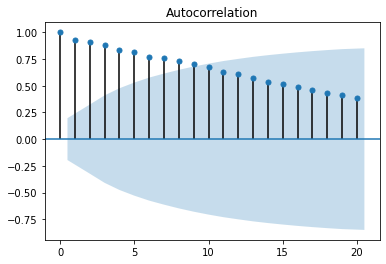

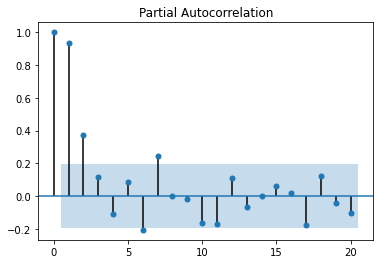

In [4]:
# ACF / PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(signal)
plot_pacf(signal)
plt.show()

# Make Time Series Stationary

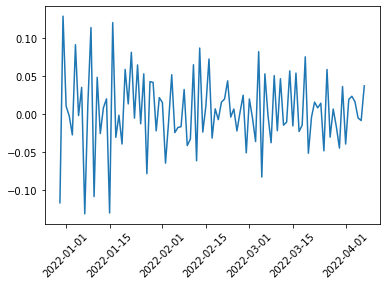

In [5]:
# Detrending

import numpy as np

log_signal = np.log(signal)
detrend_signal = log_signal - log_signal.rolling(2).mean()

plt.plot(detrend_signal)
plt.xticks(rotation=45)
plt.show()

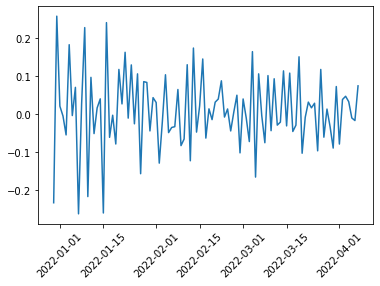

In [6]:
# Differencing

import numpy as np

log_signal = np.log(signal)
diff_signal = log_signal.diff()

plt.plot(diff_signal)
plt.xticks(rotation=45)
plt.show()

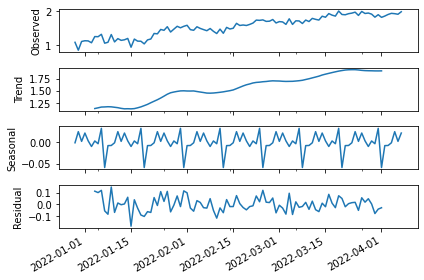

In [7]:
# Decomposing

from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

log_signal = np.log(signal)
decomposed_signal = seasonal_decompose(log_signal, freq=12)
decomposed_signal.plot()

trend_signal, season_signal, residual_signal = decomposed_signal.trend, decomposed_signal.seasonal, decomposed_signal.resid

# Forecasting using SARIMAX

In [8]:
# hyperparameter optimisation with grid search

import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = d = q = range(2)
s = 12
param_combinations = list(itertools.product(p, d, q))

lowest_aic, pdq, pdqs = None, None, None
for order in param_combinations:
  for (p, q, d) in param_combinations:
    seasonal_order = (p, q, d, s)
    
    try:
      model = SARIMAX(signal, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False, disp=False)
      model_result = model.fit(maxiter=200, disp=False)
      
      if not lowest_aic or model_result.aic < lowest_aic:
        lowest_aic = model_result.aic
        pdq, pdqs = order, seasonal_order
    except Exception as ex:
      continue

lowest_aic, order, seasonal_order = lowest_aic, pdq, pdqs
print(lowest_aic, order, seasonal_order)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


66.92333695835359 (1, 1, 0) (1, 0, 0, 12)


                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                 -30.462
Date:                            Wed, 29 Dec 2021   AIC                             66.923
Time:                                    00:20:09   BIC                             74.286
Sample:                                12-29-2021   HQIC                            69.887
                                     - 04-07-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5299      0.119     -4.447      0.000      -0.763      -0.296
ar.S.L12       0.1554      0.111   

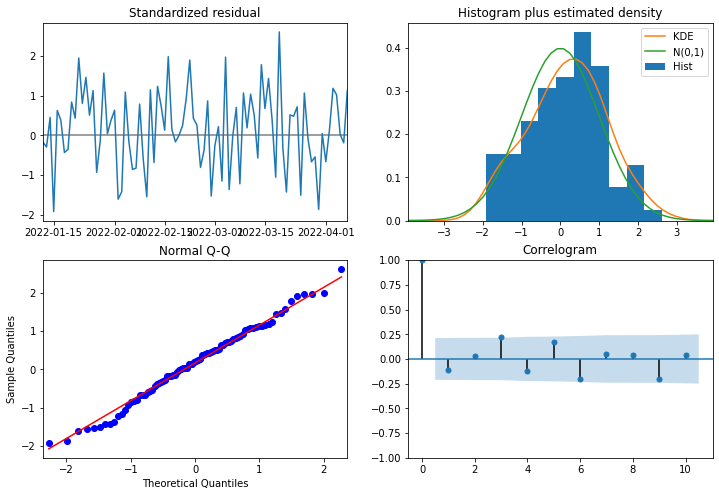

In [9]:
# fit SARIMAX model
model = SARIMAX(signal, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False, disp=False)
model_results = model.fit(maxiter=200, disp=False)
print(model_results.summary())
model_results.plot_diagnostics(figsize=(12, 8))
plt.show()

[]

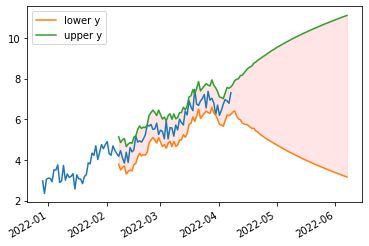

In [10]:
# do forecasting

n = len(signal.index)
prediction = model_results.get_prediction(start=n-12*5, end=n+12*5)
prediction_ci = prediction.conf_int()
ci_index, lower_ci, upper_ci = prediction_ci.index, prediction_ci.iloc[:, 0], prediction_ci.iloc[:, 1]

ax = signal.plot()
prediction_ci.plot(ax=ax)
ax.fill_between(ci_index, lower_ci, upper_ci, color="r", alpha=0.1)
plt.plot()